# Check Sky Background and zero point units from visit in Auxtel

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-05-07
- last update : 2024-05-09 
- affiliation : IJCLab/IN2P3/CNRS

  
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399


``Shemas``:
https://dm.lsst.org/sdm_schemas/browser/

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.colors import ListedColormap
from matplotlib import colors

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time
from datetime import datetime, timedelta
import seaborn as sns

from itertools import cycle, islice
import os

In [2]:
from lsst.daf.butler import Butler

import astropy.units as u
from astropy import constants as const
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom

from astropy.stats import SigmaClip


In [3]:
# INSERT YOUR auxTel/LATISS collection and tract/band HERE
butlerRoot = "/repo/embargo"


collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985'
collectionn = collection
collections = [collection]
collectionStr = collectionn.replace("/", "_")
instrument = 'LATISS'
skymapName = "latiss_v1"
where_clause = "instrument = \'" + instrument+ "\'"
tract_sel = 3864
#band = "r"
suptitle = collectionStr + f" inst = {instrument} tract = {tract_sel}"

where_clause = "instrument = \'" + instrument+ "\'"
NDET = 1

fn_ccdVisit_tracts_patches = f"ccdVisittractpatch_{collectionStr}.csv"

In [4]:
plt.rcParams["figure.figsize"] = (18,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

### Import rubinsimphot
- usefull to check the numbers

In [5]:
machine_name = os.uname().nodename
path_rubinsimphot = "repos/repos_w_2024_17/rubinsimphot/src"
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environment for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)
elif 'dagoret-nb' in machine_name:
    print("Set environment for USDF Rubin Science Platform")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)    
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environment named conda_py310")
else:
    print(f"Your current machine name is {machine_name}. Check your python environment")

Set environment for USDF Rubin Science Platform


In [6]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir

In [7]:
from rubinsimphot.phot_utils import PhotometricParameters 
from rubinsimphot.site_models import SeeingModel
from rubinsimphot.phot_utils import signaltonoise
from rubinsimphot.phot_utils import calc_neff

In [8]:
def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [9]:
fdir = get_data_dir()
#path_rubin_sim_throughput = os.path.join(fdir, 'throughputs', 'baseline')   
#hardware_filenames = ["hardware_u.dat","hardware_g.dat","hardware_r.dat","hardware_i.dat","hardware_z.dat","hardware_y.dat"] 
#filter_filenames = ["filter_u.dat","filter_g.dat","filter_r.dat","filter_i.dat","filter_z.dat","filter_y.dat" ]
#total_filenames = ["total_u.dat","total_g.dat","total_r.dat","total_i.dat","total_z.dat","total_y.dat" ]

path_rubin_sim_throughput = os.path.join(fdir, 'throughputs', 'auxtel')
hardware_filenames = ["auxtel_sdss_up_total.dat","auxtel_sdss_gp_total.dat","auxtel_sdss_rp_total.dat","auxtel_sdss_ip_total.dat","auxtel_sdss_zp_total.dat","auxtel_sdss_yp_total.dat"] 
filter_filenames = ["auxtel_sdss_up.dat","auxtel_sdss_gp.dat","auxtel_sdss_rp.dat","auxtel_sdss_ip.dat","auxtel_sdss_zp.dat" ,"auxtel_sdss_yp.dat"]
total_filenames = ["auxtel_sdss_up_total.dat","auxtel_sdss_gp_total.dat","auxtel_sdss_rp_total.dat","auxtel_sdss_ip_total.dat","auxtel_sdss_zp_total.dat","auxtel_sdss_yp_total.dat"]

In [10]:
filter_tagnames = ["u","g","r","i","z","y"]
Filter_tagnames = ["U","G","R","I","Z","Y"]
filtercolor_tagnames = ["u-g","g-r","r-i","i-z","z-y"]
Filtercolor_tagnames = ["U-G","G-R","R-I","I-Z","Z-Y"]
filter_color = ["b","g","r","orange","grey","k"]
NFILT=len(filter_filenames)

WLMIN=300.
WLMAX=1100.
WLBIN=1.
NWLBIN=int((WLMAX-WLMIN)/WLBIN)
WL=np.linspace(WLMIN,WLMAX,NWLBIN)

In [11]:
#FILTERWL = np.array([[ 324.03003755,  402.12765957,  363.59690349,   78.09762203],
#       [ 392.11514393,  561.32665832,  473.54069923,  169.21151439],
#       [ 542.3028786 ,  700.50062578,  619.49926767,  158.19774718],
#       [ 681.47684606,  827.65957447,  752.01084117,  146.18272841],
#       [ 808.63579474,  932.79098874,  868.488419  ,  124.15519399],
#       [ 914.76846058, 1044.93116395,  969.10570859,  130.16270338]])

FILTERWL = np.array([[ 353.        ,  385.        ,  369.        ,   32.        ],
                  [ 393.        ,  560.        ,  476.5       ,  167.        ],
                  [ 557.        ,  703.        ,  630.        ,  146.        ],
                  [ 688.        ,  859.        ,  773.5       ,  171.        ],
                  [ 812.        ,  938.        ,  875.76271186,  126.        ],
                  [ 934.        , 1060.        ,  997.        ,  126.        ]])

F0 = 3631.0 # Jy 1, Jy = 10^{-23} erg.cm^{-2}.s^{-1}.Hz^{-1}
Jy_to_ergcmm2sm1hzm1 = 1e-23
DT = 30.0 # seconds
gel = 1.1
#hP = 6.62607015E-34 # J⋅Hz−1
hP = 6.626196E-27
Aeff  = 9636.0 # cm2  Reff=1.2 m

#ZPT_cont =  2.5 \log_{10} \left(\frac{F_0 A \Delta T}{g_{el} h} \right)
ZPTconst = 2.5*np.log10(F0*Jy_to_ergcmm2sm1hzm1*Aeff*DT/gel/hP)

In [12]:
import sys
sys.path.append('../lib')

In [13]:
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections_auxtel import *

LSST site name validated as LSST observatory


### Import atmospheric emulator

In [14]:
from importlib.metadata import version
the_ver = version('getObsAtmo')
print(f"Version of getObsAtmo : {the_ver}")

Version of getObsAtmo : 0.1.1


In [15]:
from getObsAtmo import ObsAtmo
emul_atm = ObsAtmo()

LSST site name validated as LSST observatory


In [16]:
WL = emul_atm.GetWL()

### Import additional functions

In [17]:
def angle_in_range(alpha, lower, upper):
    return (alpha - lower) % 360 <= (upper - lower) % 360

In [18]:
def get_bbox_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    ramin,ramax,decmin,decmax in decimal degrees
    """

    xmin = bbox.beginX
    xmax = bbox.endX
    ymin = bbox.beginY
    ymax = bbox.endY
    
    radec_ll = wcs.pixelToSky(xmin, ymin)
    radec_ur = wcs.pixelToSky(xmax, ymax)
        
    return radec_ur.getRa().asDegrees(),radec_ll.getRa().asDegrees(), radec_ll.getDec().asDegrees(),radec_ur.getDec().asDegrees() 


In [19]:
def isradec_inbbox_radec(ra,dec,wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    ra: ra in degree
    dec: dec in degree
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    Bool
    
    """

    RAMIN,RAMAX,DECMIN,DECMAX = get_bbox_radec(wcs, bbox)

    flag_ra = angle_in_range(ra,RAMIN,RAMAX)
    flag_dec = angle_in_range(dec,DECMIN,DECMAX)

    flag = flag_ra and flag_dec
    return flag


In [20]:
def FindTractAndPatch(row):
    """
    Apply this function on ccdvisitTable dataframe to find the tract and patch for each visit
    """
     
    try:
        ra = row["ra"]
        dec = row["dec"]
        selectFlag = False
        # loop on tract
        for tractID in tractsId_list:
            tractInfo = skymap.generateTract(tractID)
            patches_selected = [patch.getSequentialIndex() for patch in tractInfo]
            wcs=tractInfo.getWcs()
            # loop on patches
            for patch in tractInfo:
                patchID = patch.getSequentialIndex()
                if patchID in patches_selected:
                    ibb=patch.getInnerBBox()
                    flag = isradec_inbbox_radec(ra,dec,wcs, ibb)
                    selectFlag =  selectFlag or flag
                    if selectFlag:
                        return pd.Series([tractID,patchID])
        return pd.Series([0,0])           
                
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,
        return pd.Series([0,0])  
        


## Iteration

## Initiate the butler

In [21]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collections, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
print("camera_name = {}".format(camera.getName()))
print("collections = {}".format(collections))

camera_name = LATISS
collections = ['LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985']


In [22]:
skymap = butler.get('skyMap', skymap=skymapName, collections=collections)

In [23]:
datasetRefs = butler.registry.queryDatasets(datasetType='ccdVisitTable', collections=collections, where= where_clause)

## tracts and patches

In [24]:
nImage_refs = list(butler.registry.queryDatasets('deepCoadd_nImage'))

In [25]:
tractsId_list = np.unique([ref.dataId['tract'] for ref in nImage_refs])
tractsId_list = sorted(tractsId_list)
print(tractsId_list)

[3864, 5614, 5615, 5634]


In [26]:
ccd_visit_table = butler.get('ccdVisitTable', dataId={'instrument': instrument}, collections = collections )    

In [27]:
ccd_visit_table["ccdVid"] = ccd_visit_table.index -  ccd_visit_table.index[0]
ccd_visit_table["Vid"] = ccd_visit_table["visitId"]  -   ccd_visit_table["visitId"].iloc[0]

In [28]:
#subtract the a bug number to have normal dates
ccd_visit_table["nightObs"] = ccd_visit_table.apply(lambda x: x['visitId']//100_000, axis=1)
ccd_visit_table["nightObs"]

ccdVisitId
40919696896    20230511
40919697408    20230511
40919698432    20230511
40919698944    20230511
40919699200    20230511
                 ...   
43453134336    20240308
43453134592    20240308
43453134848    20240308
43453135104    20240308
43453135360    20240308
Name: nightObs, Length: 3993, dtype: int64

In [29]:
# get time
ccd_visit_table["Time"] = pd.to_datetime(ccd_visit_table['obsStart'])

In [30]:
# get airmass
ccd_visit_table["airmass"] = ccd_visit_table["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))

In [31]:
#ccd_visit_table_subset = ccd_visit_table[["ra","dec"]].iloc[:10]
#ccd_visit_table_subset[["tractID","patchID"]] =  ccd_visit_table_subset.apply( FindTractAndPatch, axis=1,result_type ='expand')

In [32]:
# to speed up the calculation of tractID, patchID per visit, this file is saved
# or read back
if os.path.isfile(fn_ccdVisit_tracts_patches):
    print(f"{fn_ccdVisit_tracts_patches} found !!! ==> Read it !!!" )
    ccd_visit_tract_patch_table = pd.read_csv(fn_ccdVisit_tracts_patches) 
    ccd_visit_tract_patch_table.set_index("ccdVisitId",inplace=True)
    ccd_visit_tract_patch_table_only = ccd_visit_tract_patch_table[["tractID","patchID"]]
    ccd_visit_table = ccd_visit_table.join(ccd_visit_tract_patch_table_only)
else:
    print(f"{fn_ccdVisit_tracts_patches} NOT found !!! ==> Create it !!! " )
    ccd_visit_table[["tractID","patchID"]] = ccd_visit_table.apply(FindTractAndPatch, axis=1,result_type ='expand')
    columns_selected = ["ra","dec","llcra","llcdec","ulcra","ulcdec","urcra","urcdec","lrcra","lrcdec","ccdVid","Vid","nightObs","tractID","patchID","zeroPoint","airmass","skyBg","skyNoise","expTime"]
    ccd_visit_tract_patch_table = ccd_visit_table[columns_selected]
    ccd_visit_table_saved.to_csv(fn_ccdVisit_tracts_patches) 

ccdVisittractpatch_LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985.csv found !!! ==> Read it !!!


In [33]:
#ccd_visit_table[["tractID","patchID"]] = ccd_visit_table.apply( FindTractAndPatch, axis=1,result_type ='expand')

In [34]:
ccd_visit_table

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,ccdVid,Vid,nightObs,Time,airmass,tractID,patchID
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946728,-24.053747,56.749516,27.697306,7.760594,11.193549,7.856800,0.025776,0.014186,27,-0.002812,-0.001684,0.028204,0.007311,0.066781,0.043159,0.005508,0.449597,1922.977051,0.213347,0.016604,2.680115,0.159810,-24.053747,0,1.749004,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.047700,30.2434,4071,3999,239.935567,-24.128923,240.029265,-24.062575,239.957875,-23.978570,239.864202,-24.044874,0,0,20230511,2023-05-12 01:08:41.302993,1.823818,5615,295
40919697408,2023051100264,SDSSi_65mm~empty,i,239.938164,-24.036848,55.439133,27.838850,6.321881,28.073927,8.586373,0.026761,0.017073,36,0.004348,-0.017695,0.039457,0.038433,0.016566,0.088571,0.013995,0.303527,1387.484985,0.166373,0.025021,1.068607,0.207413,-24.036848,0,1.424821,170.004955,2023-05-12 01:15:04.912000,60076.052140,30.0,2023-05-12 01:14:49.912000,60076.051967,30.2335,4071,3999,239.985571,-23.974553,239.869115,-23.994653,239.890710,-24.099127,240.007258,-24.079012,512,2,20230511,2023-05-12 01:14:49.912000,1.762794,5615,295
40919698432,2023051100268,SDSSr_65mm~empty,r,239.964414,-24.045512,54.482189,27.716721,8.038972,10.700970,7.854424,0.024561,0.014016,15,0.000819,-0.009080,0.013239,0.003397,0.129652,0.081767,0.009968,0.387803,2265.302246,0.215552,0.015474,2.803484,0.165628,-24.045512,0,1.811649,323.867206,2023-05-12 01:19:39.311494,60076.055316,30.0,2023-05-12 01:19:24.311494,60076.055142,30.2379,4071,3999,239.951871,-24.120505,240.046767,-24.055593,239.976942,-23.970518,239.882074,-24.035387,1536,6,20230511,2023-05-12 01:19:24.311494,1.721301,5615,294
40919698944,2023051100270,SDSSi_65mm~empty,i,239.961137,-24.046364,53.849274,27.858833,6.754847,23.952974,8.440454,0.023946,0.012757,24,-0.006401,0.005997,0.036388,0.022835,-0.003559,0.056631,0.008252,1.230267,2129.429688,0.177205,0.021916,1.252454,0.215191,-24.046364,0,1.522426,170.004124,2023-05-12 01:22:36.150002,60076.057363,30.0,2023-05-12 01:22:21.150002,60076.057189,30.2424,4071,3999,240.008535,-23.984061,239.892085,-24.004162,239.913693,-24.108652,240.030234,-24.088534,2048,8,20230511,2023-05-12 01:22:21.150002,1.695170,5615,294
40919699200,2023051100271,SDSSi_65mm~empty,i,239.977384,-24.051453,53.394787,27.826286,6.488425,23.321407,8.416399,0.028203,0.012467,29,-0.001410,0.001387,0.026839,0.013898,0.008566,0.101609,0.015674,0.389506,1594.576904,0.185779,0.023753,1.286372,0.202669,-24.051453,0,1.462219,324.227336,2023-05-12 01:24:47.058502,60076.058878,30.0,2023-05-12 01:24:32.058502,60076.058704,30.2432,4071,3999,239.964342,-24.126362,240.059682,-24.062017,239.990410,-23.976542,239.895100,-24.040845,2304,9,20230511,2023-05-12 01:24:32.058502,1.677014,5615,294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43453134336,2024030800566,empty~SDSSy_65mm,y,122.493129,-36.203685,52.129131,26.166447,4.858362,13.559249,8.029708,0.016093,0.008375,56,0.003102,0.002562,0.026002,0.028631,0.004972,0.062312,0.012685,0.680248,1446.534058,0.026788,0.042366,2.212512,0.009526,-36.203685,0,1.094969,359.995886,2024-03-09 05:56:19.403505,60378.247447,30.0,2024-03-09 05:56:04.403505,60378.247273,30.2347,4071,3999,122.426835,-36.

## Configuration

In [35]:
am0 =1.20    # airmass
pwv0 = 5.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = 1.2 # Aerosol Angstrom exponent
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/home/d/dagoret/repos/repos_w_2024_17/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


Text(0.5, 1.0, 'Instrument throughput')

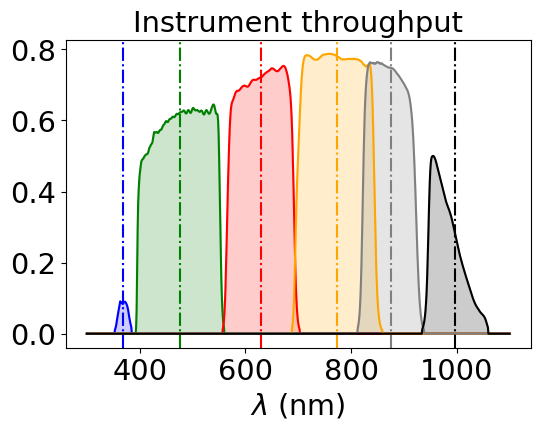

In [36]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument throughput")

Text(0.5, 1.0, 'Standard atmosphere transmission')

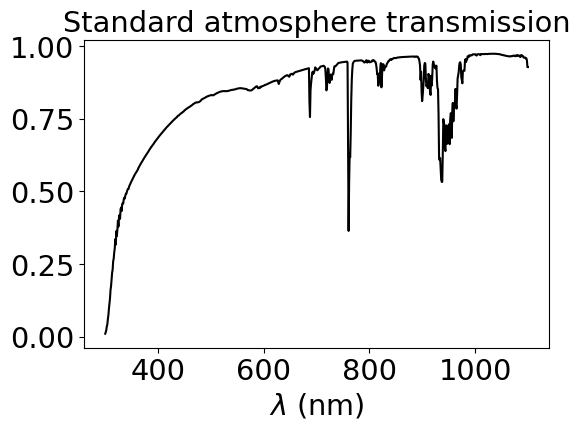

In [37]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(pc.WL,pc.atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

Text(0.5, 1.0, 'Total filter throughput')

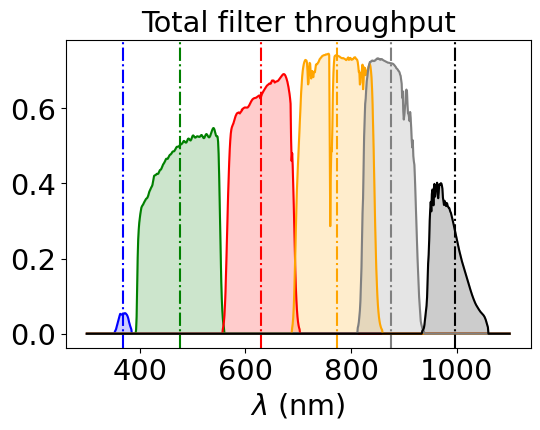

In [38]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total filter throughput")

## Zero point

In [39]:
# Calculate the standard dark sky zenith magnitudes - for reference
zeropoint_mags = {}

for index,f in enumerate(filter_tagnames):
   
    zp = pc.bandpass_total_std[f].calc_zp_t(photoparams)
    zeropoint_mags[f] = zp
    
pd.DataFrame(zeropoint_mags, index=['ZP (mag)']).round(2)

,u,g,r,i,z,y
ZP (mag),24.21,28.39,28.17,28.24,27.67,26.47


## Calculation on Dark Sky

In [40]:
path_rubin_sim_throughput=os.path.join(get_data_dir(),"throughputs/baseline")

In [41]:
darksky = Sed()
darksky.read_sed_flambda(os.path.join(path_rubin_sim_throughput, 'darksky.dat'))

In [42]:
index_sel = np.where(np.logical_and(darksky.wavelen>=WLMIN,darksky.wavelen<WLMAX))[0]
wav = darksky.wavelen[index_sel]
fll = darksky.flambda[index_sel]
darksel = Sed(wavelen=wav, flambda=fll)

Text(0, 0.5, '$F_\\lambda (\\lambda)$')

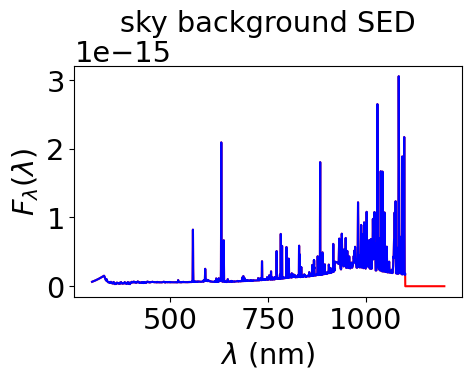

In [43]:
fig, axs = plt.subplots(1,1,figsize=(5,3))
axs.plot(darksky.wavelen,darksky.flambda,'r-')
axs.plot(darksel.wavelen,darksel.flambda,'b-')
axs.set_title("sky background SED")
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_ylabel("$F_\lambda (\lambda)$")

In [44]:
# Calculate the standard dark sky zenith magnitudes - for reference
darksky_mags = {}

for index,f in enumerate(filter_tagnames):
    
    band_wl = pc.bandpass_inst[f].wavelen
    band_tr = pc.bandpass_inst[f].sb
    darksky_mags[f] = darksky.calc_mag(pc.bandpass_inst[f])
    
pd.DataFrame(darksky_mags, index=['Dark sky magnitudes/as']).round(2)

,u,g,r,i,z,y
Dark sky magnitudes/as,23.16,22.28,21.18,20.34,19.56,18.57


### Check the instrument

#### Photometric parameters

In [45]:
# Calculate the standard dark sky zenith magnitudes - for reference
#photoparams = set_photometric_parameters(30, 1 , readnoise=None)
#photoparams._gain = 1
#photoparams._exptime = 1.
#photoparams._effarea = Aeff
#photoparams._platescale = 0.1


In [46]:
#surface : in cm2
# exposure time : in sec
# gain : electrons per ADU
# Cb = C \int Fnu S dwl/wl
# C = (pi*D^2/(4gh))* Dt = S/(gh)* Dt

photoparams._exptime = 1. 
from pprint import pprint
pprint(vars(photoparams))

{'_bandpass': None,
 '_darkcurrent': 0.2,
 '_effarea': 9636.0,
 '_exptime': 1.0,
 '_gain': 1.08269375,
 '_nexp': 1,
 '_othernoise': 0.0,
 '_platescale': 0.1,
 '_readnoise': 8.96875,
 '_sigma_sys': 0.005}


In [47]:
# Calculate the standard dark sky zenith magnitudes - for reference
darksky_adu = {}

for index,f in enumerate(filter_tagnames):
    
    band_wl = pc.bandpass_inst[f].wavelen
    band_tr = pc.bandpass_inst[f].sb
    darksky_adu[f] = darksky.calc_adu(pc.bandpass_inst[f],photoparams)
    
pd.DataFrame(darksky_adu, index=['Dark sky adu/s']).round(2)

,u,g,r,i,z,y
Dark sky adu/s,0.15,11.71,23.6,52.64,62.32,54.85


In [48]:
# Calculate the standard dark sky zenith magnitudes - for reference
photoparams = set_photometric_parameters(30, 1 , readnoise=None)

photoparams._exptime = 30.

darksky_adu = {}

for index,f in enumerate(filter_tagnames):
    
    band_wl = pc.bandpass_inst[f].wavelen
    band_tr = pc.bandpass_inst[f].sb
    darksky_adu[f] = darksky.calc_adu(pc.bandpass_inst[f],photoparams)
    
pd.DataFrame(darksky_adu, index=['Dark sky adu/expo']).round(2)

,u,g,r,i,z,y
Dark sky adu/expo,69.34,5561.65,11204.95,24997.87,29594.98,26046.91


In [49]:
ccd_visit_table_g = ccd_visit_table[ccd_visit_table["band"] == 'g']
ccd_visit_table_r = ccd_visit_table[ccd_visit_table["band"] == 'r']
ccd_visit_table_i = ccd_visit_table[ccd_visit_table["band"] == 'i']
ccd_visit_table_z = ccd_visit_table[ccd_visit_table["band"] == 'z']
ccd_visit_table_y = ccd_visit_table[ccd_visit_table["band"] == 'y']

## Sky Background

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS tract = 3864')

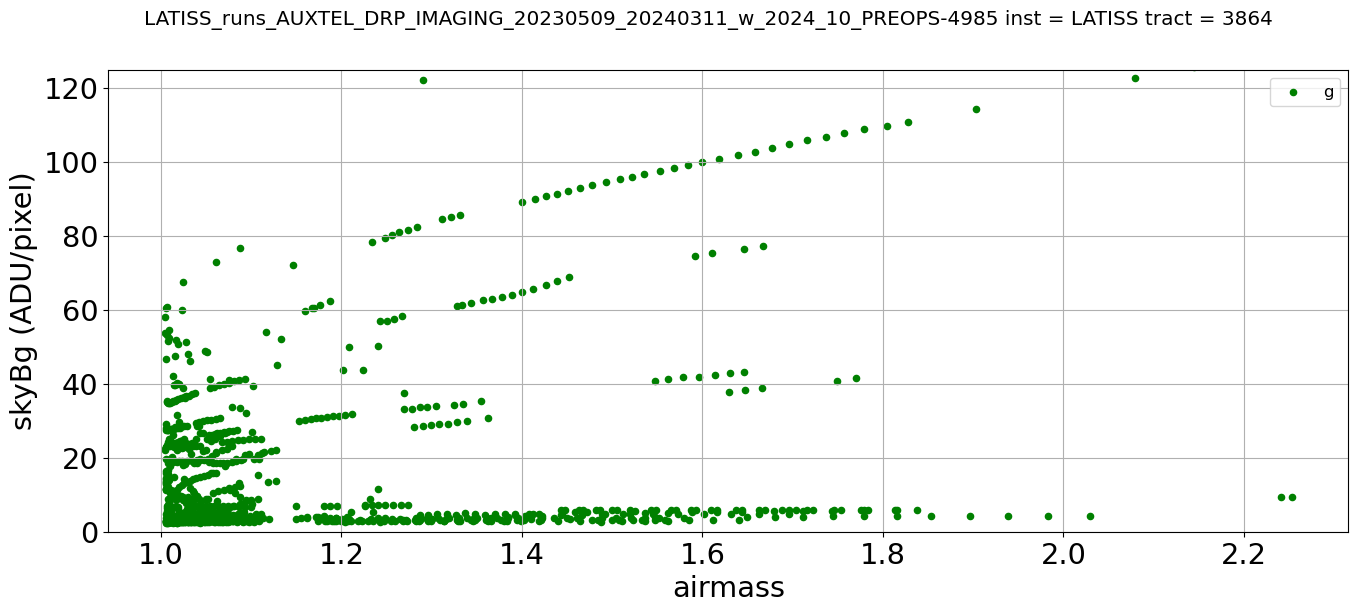

In [50]:
fig, ax = plt.subplots(1,1,figsize=(16,6),sharex=True)
ccd_visit_table_g.plot.scatter(x="airmass",y="skyBg",marker="o",ax=ax,color="g",grid=True,label="g",ylabel="skyBg (ADU/pixel)")
ax.set_ylim(0.,125)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS tract = 3864')

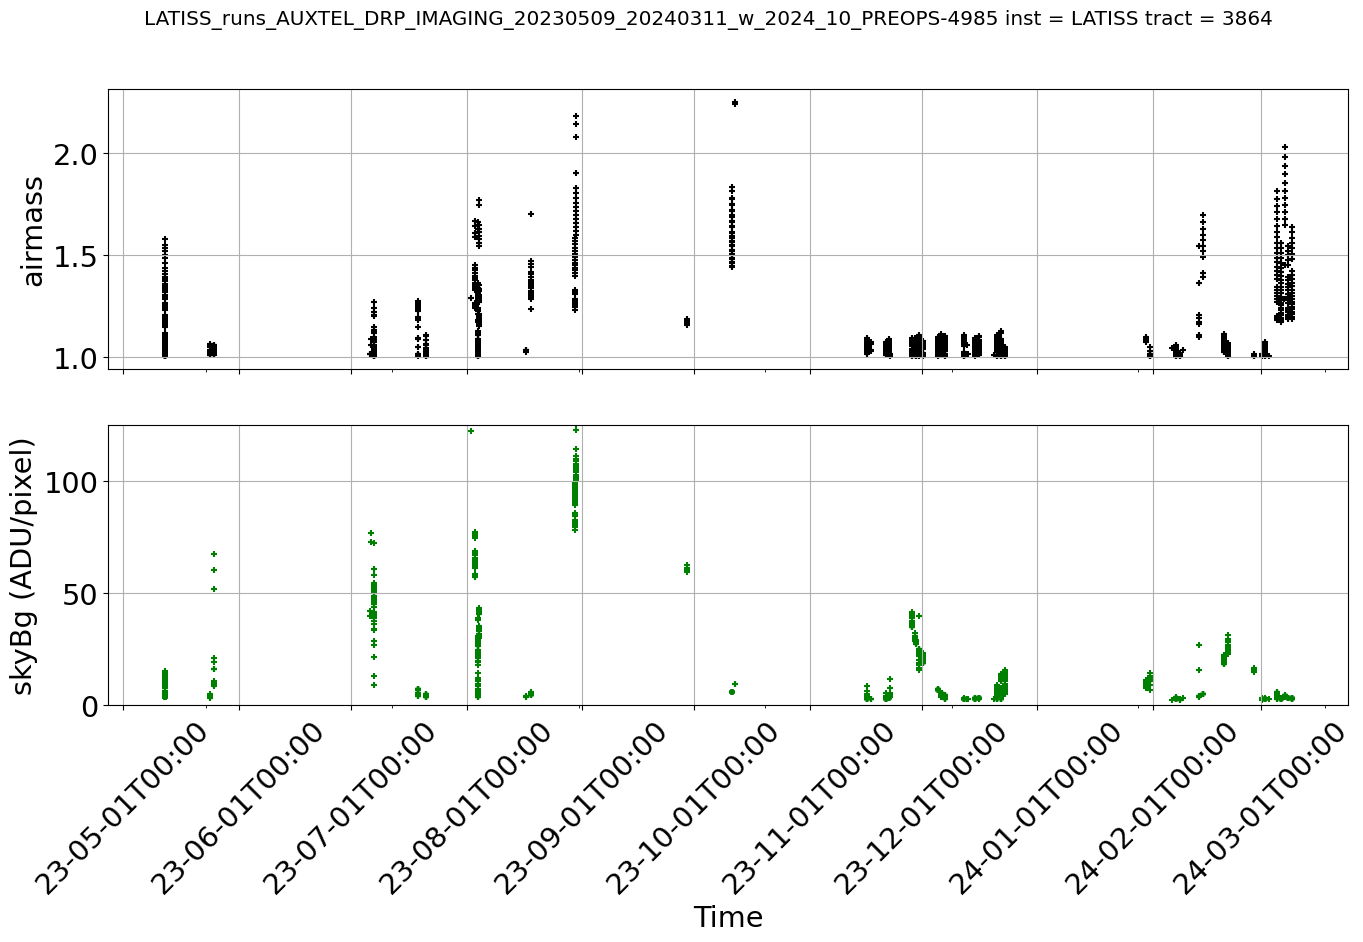

In [51]:
import matplotlib.dates as mdates
#month_locator = mdates.MonthLocator(interval=1)
#day_locator = mdates.DayLocator(interval=1)
#year_month_formatter = mdates.DateFormatter("%Y-%m") 

from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")


fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,8),sharex=True)
ccd_visit_table_g.plot.scatter(x="Time",y="airmass",ax=ax1,marker="+",color="k",rot=45)
ccd_visit_table_g.plot.scatter(x="Time",y="skyBg",ax=ax2,marker="+",color="g",rot=45,ylabel="skyBg (ADU/pixel)")
ax2.xaxis.set_major_formatter(date_form)

#ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
#ax.xaxis.set_minor_locator(day_locator)
#ax.xaxis.set_major_formatter(year_month_formatter)
ax1.grid()
ax2.grid()
ax2.set_ylim(0.,125)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS tract = 3864')

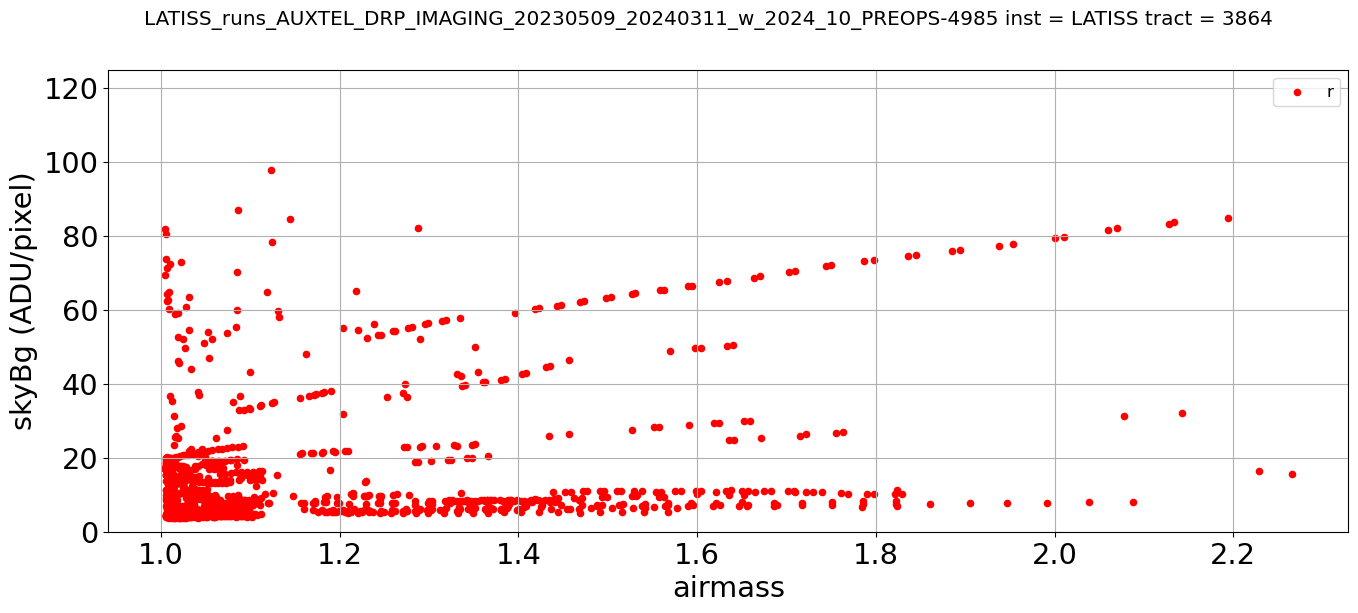

In [52]:
fig, ax = plt.subplots(1,1,figsize=(16,6),sharex=True)
ccd_visit_table_r.plot.scatter(x="airmass",y="skyBg",marker="o",ax=ax,color="r",grid=True,label="r",ylabel="skyBg (ADU/pixel)")
ax.set_ylim(0.,125)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS tract = 3864')

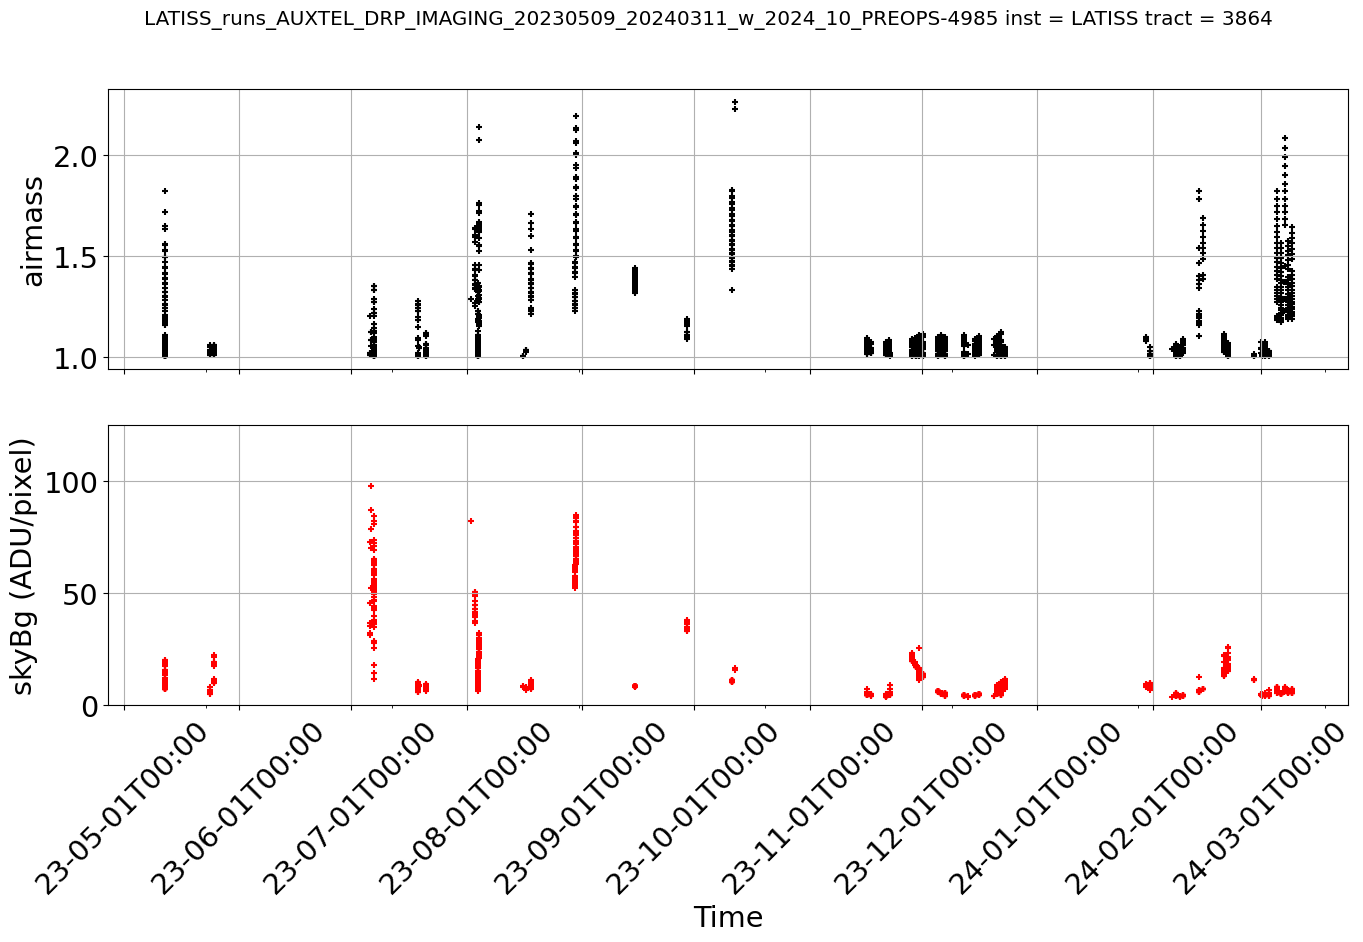

In [53]:
import matplotlib.dates as mdates

from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")


fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,8),sharex=True)
ccd_visit_table_r.plot.scatter(x="Time",y="airmass",ax=ax1,marker="+",color="k",rot=45)
ccd_visit_table_r.plot.scatter(x="Time",y="skyBg",ax=ax2,marker="+",color="r",rot=45,ylabel="skyBg (ADU/pixel)")
ax2.xaxis.set_major_formatter(date_form)

#ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
#ax.xaxis.set_minor_locator(day_locator)
#ax.xaxis.set_major_formatter(year_month_formatter)
ax1.grid()
ax2.grid()
ax2.set_ylim(0.,125)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS tract = 3864')

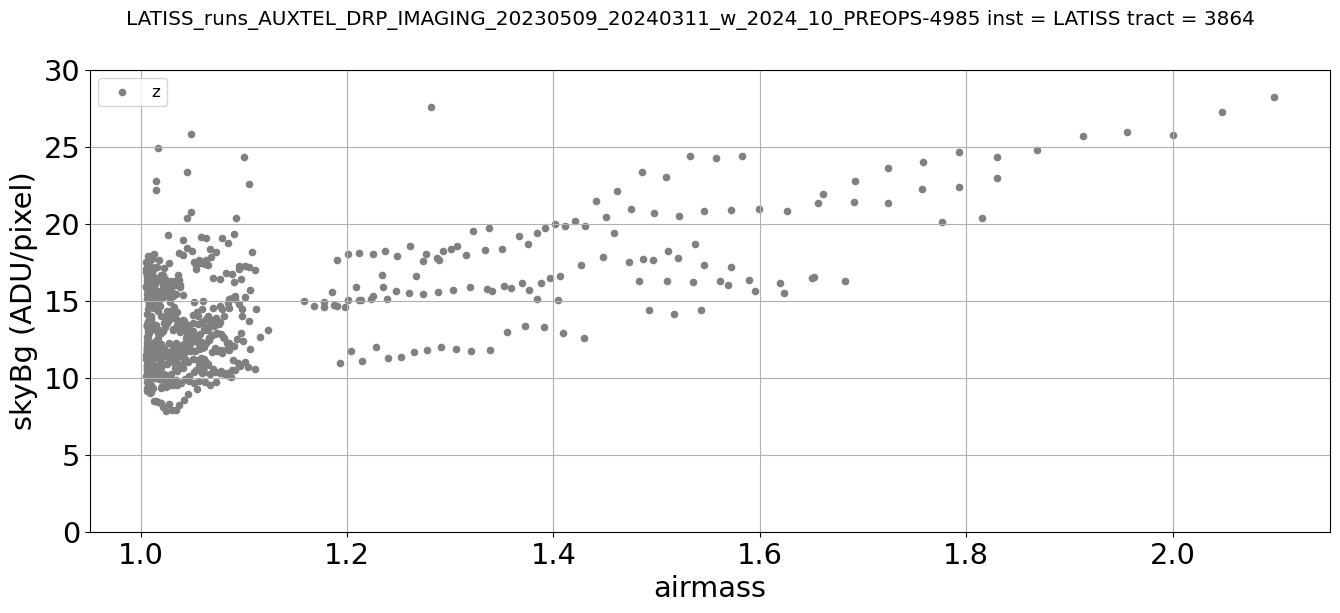

In [54]:
fig, ax = plt.subplots(1,1,figsize=(16,6),sharex=True)
ccd_visit_table_z.plot.scatter(x="airmass",y="skyBg",marker="o",ax=ax,color="grey",grid=True,label="z",ylabel="skyBg (ADU/pixel)")
ax.set_ylim(0.,30)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS tract = 3864')

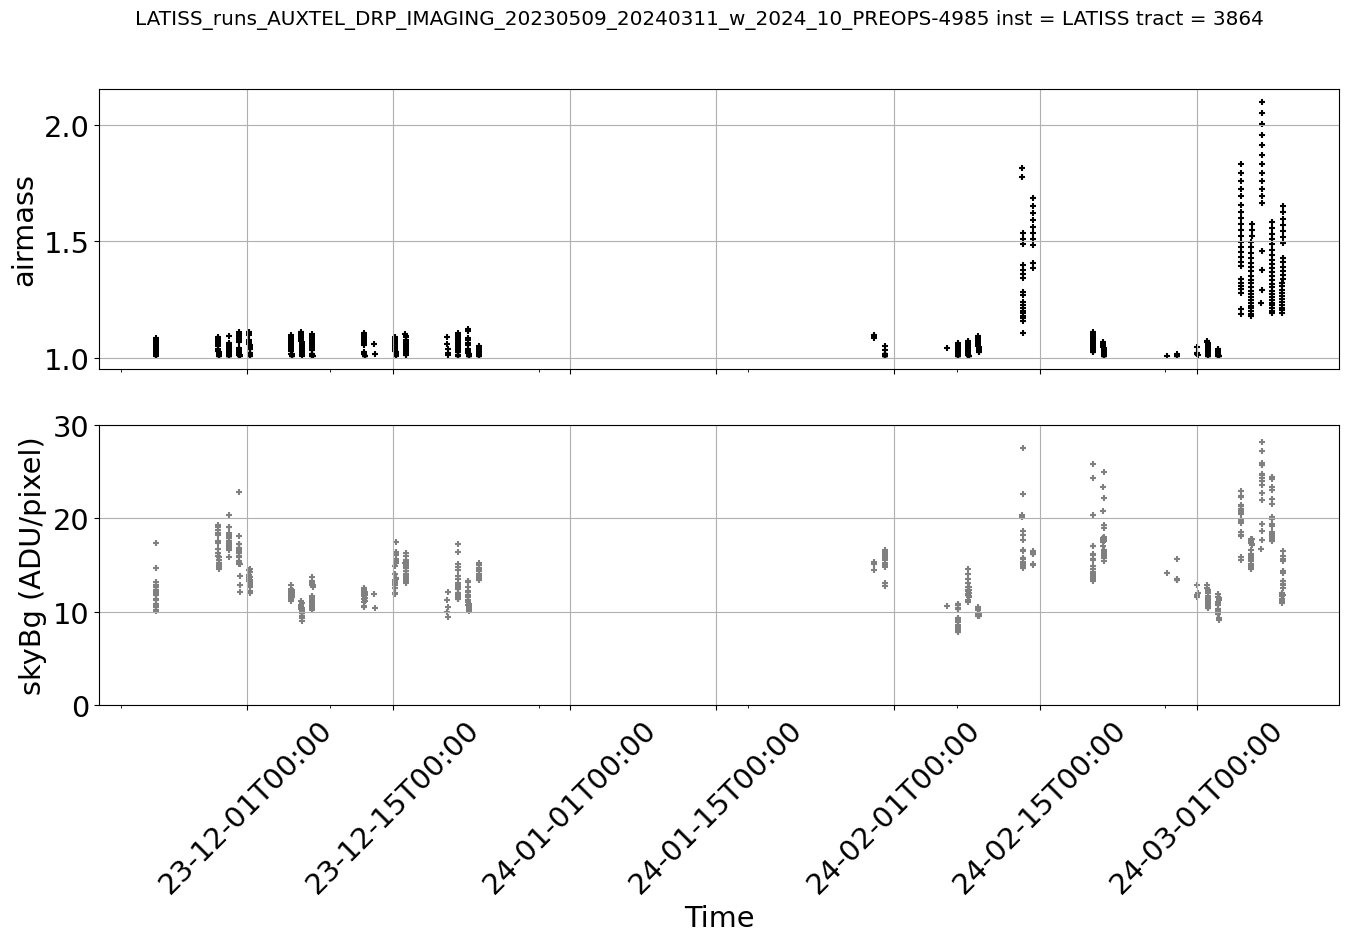

In [55]:
import matplotlib.dates as mdates

from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")


fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,8),sharex=True)
ccd_visit_table_z.plot.scatter(x="Time",y="airmass",ax=ax1,marker="+",color="k",rot=45)
ccd_visit_table_z.plot.scatter(x="Time",y="skyBg",ax=ax2,marker="+",color="grey",rot=45,ylabel="skyBg (ADU/pixel)")
ax2.xaxis.set_major_formatter(date_form)

#ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
#ax.xaxis.set_minor_locator(day_locator)
#ax.xaxis.set_major_formatter(year_month_formatter)
ax1.grid()
ax2.grid()
ax2.set_ylim(0.,30)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS tract = 3864')

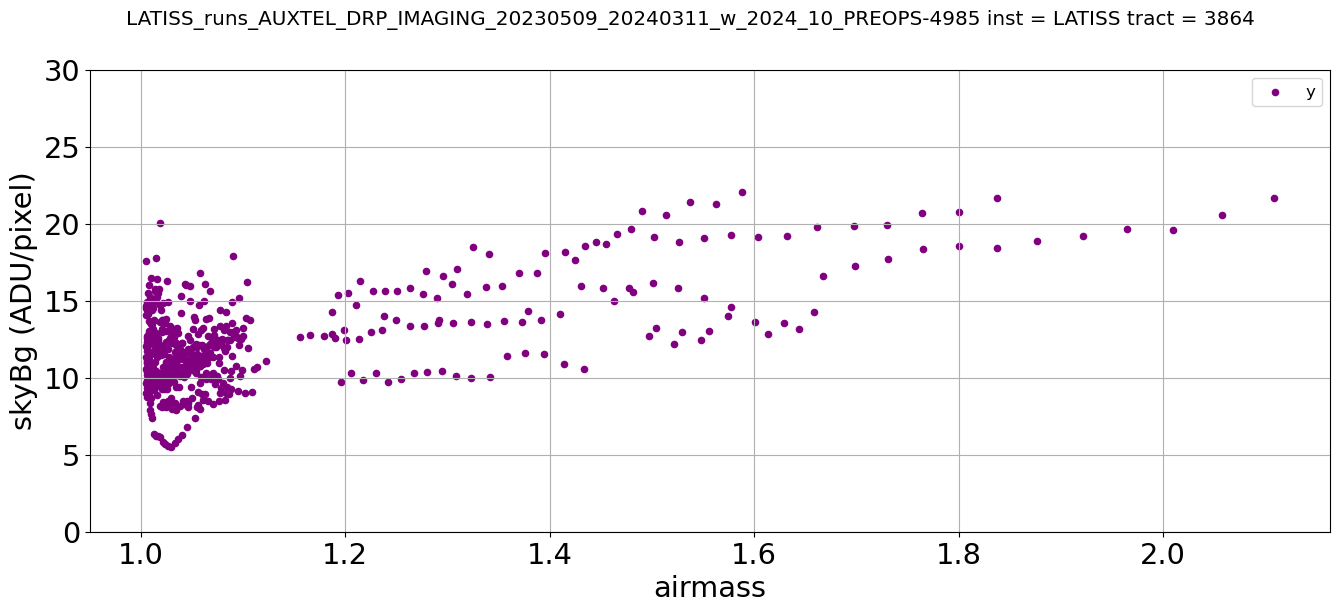

In [56]:
fig, ax = plt.subplots(1,1,figsize=(16,6),sharex=True)
ccd_visit_table_y.plot.scatter(x="airmass",y="skyBg",marker="o",ax=ax,color="purple",grid=True,label="y",ylabel="skyBg (ADU/pixel)")
ax.set_ylim(0.,30)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985 inst = LATISS tract = 3864')

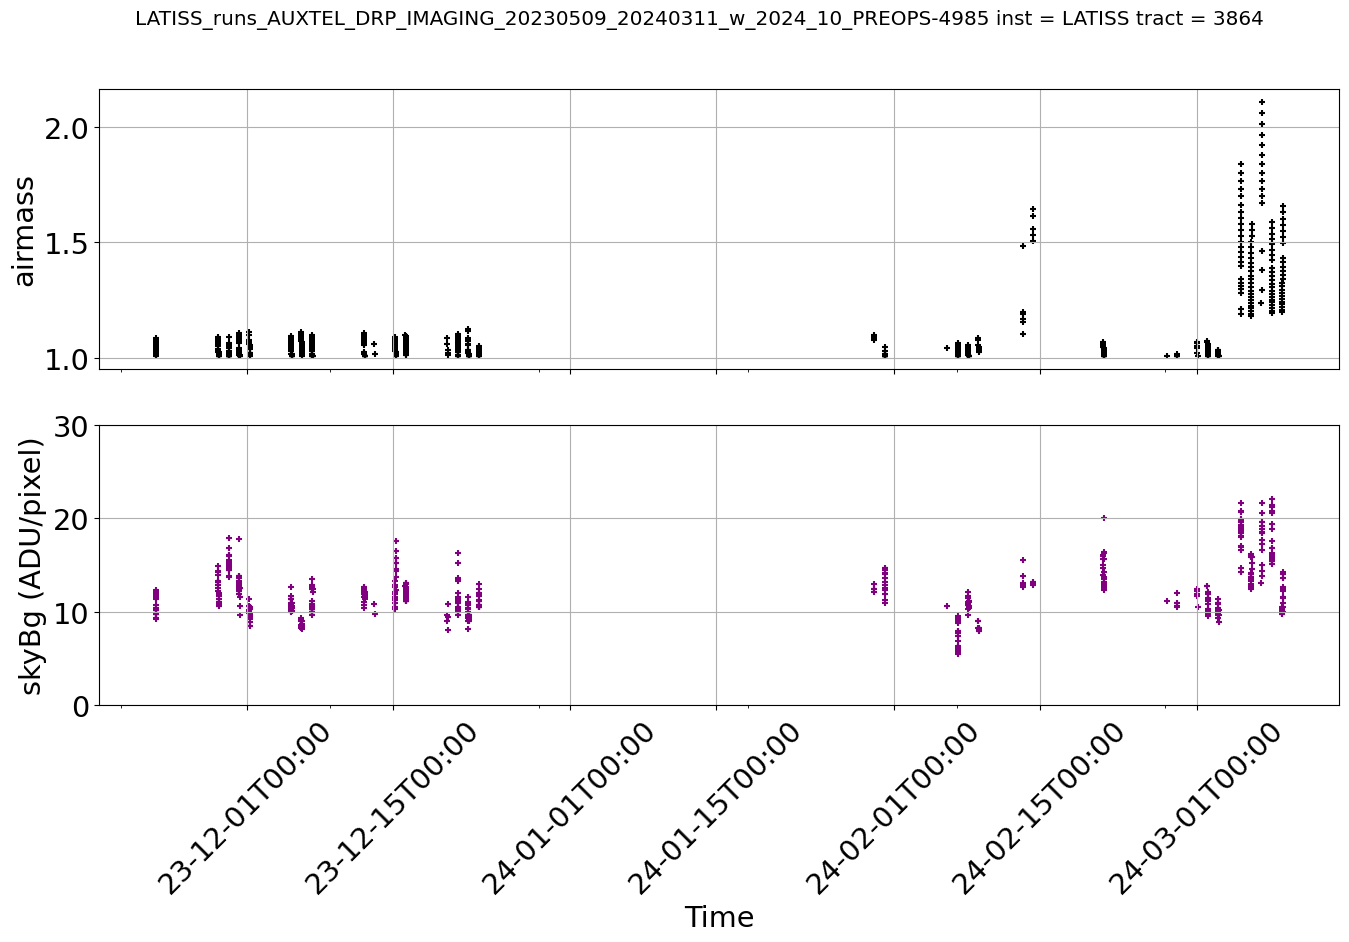

In [57]:
import matplotlib.dates as mdates

from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")


fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,8),sharex=True)
ccd_visit_table_y.plot.scatter(x="Time",y="airmass",ax=ax1,marker="+",color="k",rot=45)
ccd_visit_table_y.plot.scatter(x="Time",y="skyBg",ax=ax2,marker="+",color="purple",rot=45,ylabel="skyBg (ADU/pixel)")
ax2.xaxis.set_major_formatter(date_form)

#ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
#ax.xaxis.set_minor_locator(day_locator)
#ax.xaxis.set_major_formatter(year_month_formatter)
ax1.grid()
ax2.grid()
ax2.set_ylim(0.,30)
plt.suptitle(suptitle)